In [29]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
sys.path.append("/Users/jameskitchens/Documents/GitHub/tskit_arg_visualizer")
import tskit_arg_visualizer as tsviz
importlib.reload(tsviz)
import pandas as pd
import tskit
import numpy as np
import matplotlib.pyplot as plt

In [30]:
demes = pd.read_csv("dataset/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)

tct.create_samples_and_arg_files(
    demes_path="dataset/demes.tsv",
    number_of_samples=100,
    sequence_length=10_000,
    recombination_rate=1e-8,
    ploidy=1,
    allow_multiple_samples_per_deme=True,
    pop_size=500,
    migration_rate=0.01,
    output_directory="dataset"
)

In [31]:
def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

In [32]:
ts = tskit.load("dataset/arg.trees")
print(ts)
ts, map_nodes = simplify_with_recombination(ts)
d3arg = tsviz.D3ARG.from_ts(ts)
d3arg.draw(width=2000, height=1000)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          3║
╟───────────────┼───────────╢
║Sequence Length│      10000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │        100║
╟───────────────┼───────────╢
║Total Size     │   26.3 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 328│ 10.3 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│ 100│  2.8 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │ 327│  8.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   2│265 Bytes│         Yes║
╟───────────┼────┼────

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_17552/1673828240.py:30: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents.


In [33]:
sample_locations = pd.read_csv("dataset/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

In [16]:
migration_rates = []
for m in range(8,-1,-1):
    for i in range(1,10):
        migration_rates.append(i*10**(-m))

by_tree = []
for m0 in migration_rates:
    ll = tct.calc_migration_rate_log_likelihood(
        world_map=world_map,
        trees=ts.trees(),
        sample_location_vectors=sample_location_vectors,
        migration_rates={0:m0}
    )
    by_tree.append(ll[1])
    print(m0, ll[0])

1e-08 -494.4975186577617
2e-08 -472.31684706150804
3.0000000000000004e-08 -459.34200178400874
4e-08 -450.1362136478116
5e-08 -442.99565818831434
6.000000000000001e-08 -437.16140655376284
7e-08 -432.2286229824433
8e-08 -427.95565660190897
9e-08 -424.18663764465276
1e-07 -420.8151393276479
2e-07 -398.63481140655085
3e-07 -385.6603098336575
4e-07 -376.4548654315038
5e-07 -369.3146537354753
6e-07 -363.4807458938066
7e-07 -358.5483061447718
8e-07 -354.2756836159124
9e-07 -350.50700853970955
1e-06 -347.1358541331248
2e-06 -324.9589669288145
3e-06 -311.987908996482
4e-06 -302.7859111469947
4.9999999999999996e-06 -295.6491489041282
6e-06 -289.8186934045637
7e-06 -284.88970887507946
8e-06 -280.6205444317777
9e-06 -276.85533029575635
1e-05 -273.48763967264966
2e-05 -251.34554423162717
3.0000000000000004e-05 -238.4095503328719
4e-05 -229.2428783254078
5e-05 -222.14169375409648
6.000000000000001e-05 -216.34705822935902
7.000000000000001e-05 -211.45412687646194
8e-05 -207.22124010898793
9e-05 -203.

In [49]:
print(by_tree)

[[np.float64(-277.59341517940635), np.float64(-277.59341517940635), np.float64(-277.59421258027777), np.float64(-277.59420072237475), np.float64(-277.5942007223748)], [np.float64(-265.11680844219427), np.float64(-265.1168084421943), np.float64(-265.11761356667785), np.float64(-265.1175898514249), np.float64(-265.1175898514249)], [np.float64(-257.8184790089671), np.float64(-257.81847900896713), np.float64(-257.81929185646993), np.float64(-257.8192562844199), np.float64(-257.81925628441985)], [np.float64(-252.64024421740763), np.float64(-252.64024421740763), np.float64(-252.64106478733697), np.float64(-252.6410173590428), np.float64(-252.64101735904282)], [np.float64(-248.6237028061771), np.float64(-248.6237028061771), np.float64(-248.62453109794023), np.float64(-248.6244718139549), np.float64(-248.6244718139549)], [np.float64(-245.34195729616397), np.float64(-245.34195729616394), np.float64(-245.34279330916814), np.float64(-245.34272217004454), np.float64(-245.34272217004454)], [np.floa

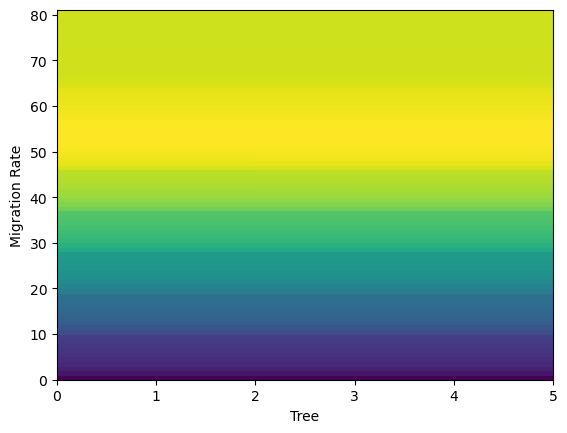

In [48]:
plt.pcolor(by_tree, linewidths=1)
plt.xlabel("Tree")
plt.ylabel("Migration Rate")
plt.show()

In [80]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(time=100000000)
node_table.add_row(time=200000000)
node_table.add_row(time=300000000)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 500, 0]),
    right=np.array([1e3, 1e3, 500, 1e3, 1e3]),
    parent=np.array([2, 3, 3, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([0, 1, 2, 2, 3], dtype=np.int32),  # References IDs in the node table
)

g = tables.tree_sequence()
print(g.draw_text())

300000000.00┊  4  ┊  4  ┊  
            ┊  ┃  ┊ ┏┻┓ ┊  
200000000.00┊  3  ┊ ┃ 3 ┊  
            ┊ ┏┻┓ ┊ ┃ ┃ ┊  
100000000.00┊ 2 ┃ ┊ 2 ┃ ┊  
            ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00        ┊ 0 1 ┊ 0 1 ┊  
            0    500  1000 



In [81]:
tree0 = g.first()
tree1 = g.last()

In [82]:
migration_rates = []
for m in range(8,-1,-1):
    for i in mult:
        migration_rates.append(i*10**(-m))

In [83]:
for m0 in migration_rates:
    ll = tct.calc_migration_rate_log_likelihood(
        world_map=world_map,
        trees=[tree0],
        sample_location_vectors=sample_location_vectors,
        migration_rates={0:m0}
    )[0]
    print(ll)

-2.5261902967694976
-2.3108347222225674
-2.302585092994078
-2.302585092994017
-2.302585092996821
-2.3025850929636213
-2.302585092387564
-2.3025851046886636
-2.302585048654473


In [30]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=1)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)
node_table.add_row(flags=tskit.NODE_IS_SAMPLE, time=1)
node_table.add_row(time=2)
node_table.add_row(time=3)

edge_table = tables.edges
edge_table.set_columns(
    left=np.array([0, 0, 0, 0]),
    right=np.array([1e3, 1e3, 1e3, 1e3]),
    parent=np.array([3, 3, 4, 4], dtype=np.int32),  # References IDs in the node table
    child=np.array([1, 2, 0, 3], dtype=np.int32),  # References IDs in the node table
)

gprime = tables.tree_sequence()
print(gprime.draw_text())

3.00┊   4   ┊  
    ┊ ┏━┻┓  ┊  
2.00┊ ┃  3  ┊  
    ┊ ┃ ┏┻┓ ┊  
1.00┊ 0 ┃ 2 ┊  
    ┊   ┃   ┊  
0.00┊   1   ┊  
    0     1000 



In [33]:
for i in range(10):
    sample_locations_gprime = pd.DataFrame({"id":[0,1,2], "deme":[i,6,i]})
    sample_location_vectors_gprime = world_map.build_sample_location_vectors(sample_locations=sample_locations_gprime)